In [1]:
import copy
import geopandas as gpd 
from datetime import datetime, timedelta
import dateparser
from shapely.geometry import MultiPolygon, Polygon

# Raw salient forecasts from bucket / API
from sheerwater_benchmarking.forecasts.salient import salient_blend_raw, salient_blend
from sheerwater_benchmarking.reanalysis.salient_era5 import salient_era5_raw, salient_era5

# Processed Salient data
from sheerwater_benchmarking.forecasts import salient

# Metrics 
from sheerwater_benchmarking.metrics import summary_metrics_table_salient

# Utils
from sheerwater_benchmarking.utils import start_remote, clip_region, apply_mask, salient_secret

# Salient functions
from salientsdk.skill import _crps_core

In [2]:
start_remote(remote_name='genevieve', remote_config='xlarge_cluster')

Output()

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

import salientsdk as sk

## Run tests on Salient evaluation period, for a specific variable and lead

In [4]:
start_time = '2015-01-01'
end_time = '2022-12-31'
variable = 'tmp2m'
grid = 'salient0_25'
metric = 'crps'
region = 'africa'
mask = 'lsm'
lead = 'week3'

## First, replicate logic of ground truth and forecast alignment from raw data

In [5]:
# Get the raw forecast data, clip to Africa, and rename
lead_id = {"week1": 1, "week2": 2, "week3": 3, "week4": 4, "week5": 5}[lead]
fcst_ds = clip_region(salient_blend(start_time, end_time, variable, grid='salient0_25'), 'africa')
fcst_ds = fcst_ds.rename(forecast_date='time').sel(lead=lead_id)

Cache doesn't exist for salient_blend/salient0_25_sub-seasonal_tmp2m. Running function


/Users/avocet/content/sheerwater-benchmarking/.venv/lib/python3.12/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "forecast_date" starting at index 3. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


Caching result for gs://sheerwater-datalake/caches/salient_blend/salient0_25_sub-seasonal_tmp2m.zarr.


In [7]:
# Prepare the ground truth, with appropriate shifting to match the lead of interest
gt_ds = clip_region(salient_era5_raw(None, None, variable, validate_cache_timeseries=False), 'africa')

# Take a rolling mean over weekly day periods
gt_ds_agg = gt_ds.rolling(time=7, min_periods=7, center=False).mean()
# Drop the nan values added by the rolling aggregation at the end
gt_ds_agg = gt_ds_agg.dropna("time", how="all")

# Correct coords to left-align the aggregated window
# (default is right aligned)
# For example, the 7 day average from 2015-01-01 to 2015-01-07 will be returned on 2015-01-07,
# and then corrected to 2015-01-01
gt_ds_agg = gt_ds_agg.assign_coords(time=gt_ds_agg["time"] - np.timedelta64(6, 'D'))

Found cache for gs://sheerwater-datalake/caches/salient_era5_raw/salient0_25_tmp2m.zarr
Opening cache gs://sheerwater-datalake/caches/salient_era5_raw/salient0_25_tmp2m.zarr


In [8]:
gt_ds_agg

<xarray.Dataset> Size: 1GB
Dimensions:      (lat: 290, lon: 324, time: 2961)
Coordinates:
  * lat          (lat) float32 1kB -34.88 -34.62 -34.38 ... 36.88 37.12 37.38
  * lon          (lon) float32 1kB -22.88 -22.62 -22.38 ... 57.38 57.62 57.88
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 24kB 2014-12-27 2014-12-28 ... 2023-02-03
Data variables:
    tmp2m        (time, lat, lon) float32 1GB dask.array<chunksize=(2961, 290, 324), meta=np.ndarray>

In [9]:
# How much to shift ERA5 data to match leads for each lead. 
lead_params = {
    "week1": 0,
    "week2": 7,
    "week3": 14,
    "week4": 21,
    "week5": 28,
    "week6": 35,
}
time_shift = lead_params.get(lead, None)
if time_shift is None:
    raise NotImplementedError(f"Lead {lead} not implemented for Salient ERA5.")

# Move our start and end time over by the time shift value
# For example, a 2 week lead forecast on 2015-01-01 needs to be compared to the weekly value for ERA5
# starting on 2015-01-15 and ending on 2015-01-21 (inclusive)
new_start = datetime.strftime(dateparser.parse(start_time)+timedelta(days=time_shift), "%Y-%m-%d")
new_end = datetime.strftime(dateparser.parse(end_time)+timedelta(days=time_shift), "%Y-%m-%d")

# Filter the ground truth to that window
gt_ds_agg = gt_ds_agg.sel(time=slice(new_start, new_end))
                          
# Update the time label to match the forecast date 
# This will update the ground truth on 2015-01-15 to 2015-01-01, 
# indicating that this is the week2 lead ground truth for a forecast made on 2015-01-01 
gt_ds_agg = gt_ds_agg.assign_coords(time=gt_ds_agg['time']-np.timedelta64(time_shift, 'D'))

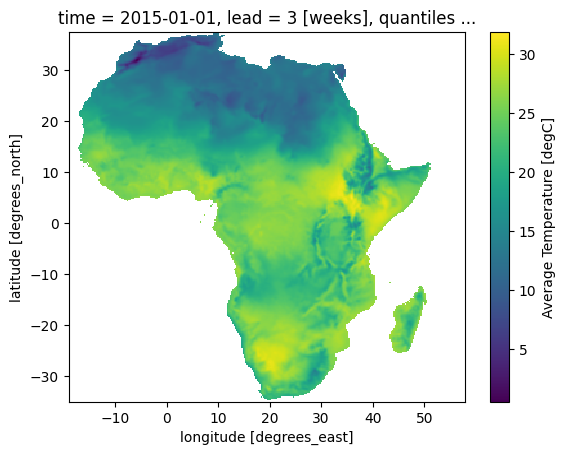

In [10]:
# Plot example data
fcst_ds[variable].sel(time="2015-01-01", quantiles=0.5).plot(x='lon')

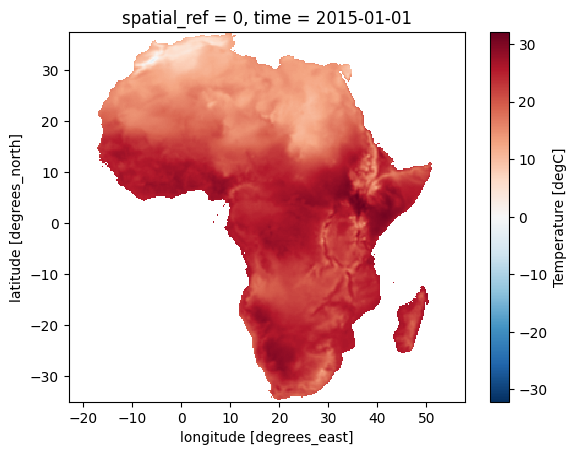

In [11]:
# Plot example ground truth
gt_ds_agg[variable].sel(time="2015-01-01").plot(x='lon')

In [12]:
# Compute CRPS on the aligned dataframes
met_ds = _crps_core(observations=gt_ds_agg, forecasts=fcst_ds, qnt_dim='quantiles')

In [ ]:
# Average over space and time
met = float(met_ds.mean()['crps'] .compute())
print(met)

## Then, compute the same value using our evaluation pipeline

In [ ]:
fcst_ds = salient(start_time, end_time, variable, lead='week3', grid='salient0_25', prob_type='probabilistic', region='africa')
gt_ds = salient_era5(start_time, end_time, variable, lead='week3', grid='salient0_25', region='africa')

In [ ]:
from weatherbench2.metrics import SpatialQuantileCRPS
# Compute using SalientSDK, but divide by 7 to acccount for total precip versus daily precip
met1 = float(_crps_core(observations=gt_ds, forecasts=fcst_ds, qnt_dim='member').mean()['crps'].compute()) / 7.0
# Compute using WeatherBench metric used in Nimbus, but divide by 7 to acccount for total precip versus daily precip
met2 = float(SpatialQuantileCRPS(quantile_dim='member').compute(forecast=fcst_ds, truth=gt_ds, skipna=True).mean()[variable].compute()) / 7.0
print(met1, met2)

## Finally, compared to our pre-computed values

In [ ]:
# Get value from our cached table [should match exactly for week 3]
tab = summary_metrics_table_salient(start_time, end_time, variable, 
                           truth='salient_era5', metric=metric,                            
                           grid=grid, mask='lsm', region="africa")
tab = tab.set_index('forecast')
# Divide by 7, to convert weekly totals to daily averages 
tab = (tab[['week1', 'week2', 'week3', 'week4', 'week5']] / 7.).T
tab

## Get Salient Hindcast Summary for Comparison

<Axes: >

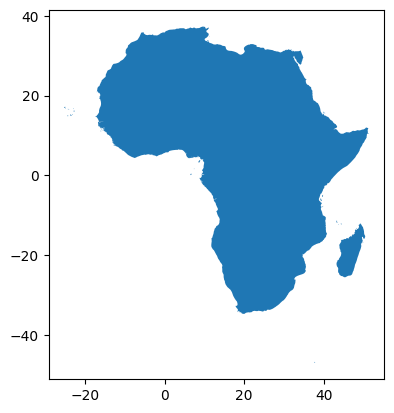

In [25]:
# Get an african bounding geojson, the same as is used to clip above, and prep for Salient loc
mask = gpd.read_file('/Users/avocet/content/sheerwater-benchmarking/africa.geojson')
# Add a dummy column for grouping
mask['group'] = 1

# Dissolve all countries into a single outline
full_mask = mask.dissolve(by='group')
full_geom = full_mask.geometry[1]

# Initialize an empty list to hold all coordinates
all_coordinates = [list(poly.exterior.coords) for poly in full_geom.geoms]
# Flatten
all_coordinates = [coord for poly_coords in all_coordinates for coord in poly_coords]
full_mask.plot()

In [32]:
username, password = salient_secret()
sk.login(username, password)
loc = sk.Location(shapefile=sk.upload_shapefile(
    coords=all_coordinates,
    geoname="africa_region", # the full African continent
    force=True)) 

In [33]:
# The variable that we'll be evaluating.
var = {"tmp2m": "temp", "precip": "precip"}[variable]
fld = "vals"
timescale = "sub-seasonal"
ref_model = "clim"  # Works across all timescale values.

skill_summ = pd.read_csv(
    sk.hindcast_summary(
        loc=loc,
        metric="crps",
        variable=var,
        timescale=timescale,
        reference=ref_model,
        split_set="test",
    )
)
print(skill_summ.drop(columns="Reference Model"))

     Lead  Reference CRPS  Salient CRPS  Salient CRPS Skill Score (%)
0  Week 1            0.54          0.36                          34.6
1  Week 2            0.54          0.47                          13.5
2  Week 3            0.54          0.51                           5.7
3  Week 4            0.54          0.52                           3.4
4  Week 5            0.54          0.52                           2.8


## Merge and Compare

In [53]:
merged_df = copy.copy(tab)
merged_df['salient_hindcast'] = skill_summ['Salient CRPS'].values
merged_df.index.names = ['Lead']
merged_df.columns = ["Salient Nimbus", "Salient Hindcast Summary"]
merged_df["Difference (%)"] = 100*(merged_df["Salient Nimbus"] - merged_df[ "Salient Hindcast Summary"]) / merged_df["Salient Nimbus"]

In [54]:
merged_df

,Salient Nimbus,Salient Hindcast Summary,Difference (%)
Lead,,,
week1,0.426978,0.36,15.686596
week2,0.544665,0.47,13.708385
week3,0.594312,0.51,14.186479
week4,0.611091,0.52,14.906242
week5,0.617978,0.52,15.854590
